原理就是采用预训练网络抽取内容图片特征和风格图片特征，然后把内容图片特征和风格图片特征合并，最后用合并后的特征生成图片。
![img](total.png)

风格迁移中常用的损失函数由三部分组成：
<br>(i)内容损失使合成图像与内容图像在内容特征上接近;
<br>(ii)风格损失使合成图像与风格图像的风格特征接近;
<br>(iii)总的变化损失有助于降低合成图像中的噪声

d:\Miniconda3\envs\pytorch_basic\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


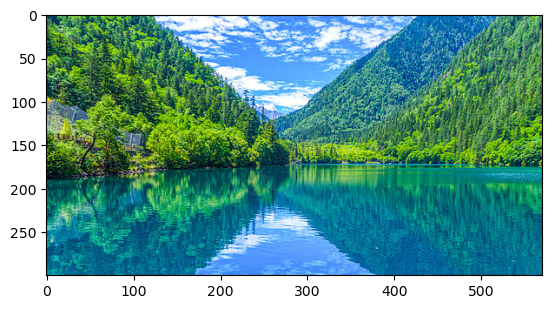

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image

content = Image.open('content.jpg')
plt.imshow(content)


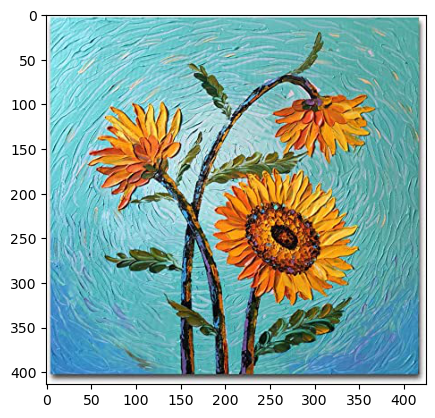

In [2]:
style = Image.open('style.jpg')
plt.imshow(style)

In [3]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

## 前处理
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),  # 首先两张图片的尺寸肯定要裁剪一致
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)]) # 归一化输出
    return transforms(img).unsqueeze(0)

## 后处理
def postprocess(img):
    img = img[0].to(rgb_std.device)
    # 反归一化，还原图片，同时pytorch中通道数是在前面，所以要permute一下
    #clamp函数是将图片的像素值限制在0-1之间
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

### 特征提取

In [4]:
'''
we can select the output of certain layers in the VGG network. 
Generally speaking, the closer to the input layer, the easier to extract details of the image, 
and vice versa, the easier to extract the global information of the image.

'''
# 加载预训练模型
pretrained_net = torchvision.models.vgg19(pretrained=True)

# We also select the output of different VGG layers for extracting local and global style features
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])   # 取网络的前29层即可
print(net)

d:\Miniconda3\envs\pytorch_basic\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\Miniconda3\envs\pytorch_basic\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Given the input X, if we simply invoke the forward propagation net(X), we can only get the output of the last layer. Since we also need the outputs of intermediate layers, we need to perform layer-by-layer computation and keep the content and style layer outputs.

In [5]:
# 必须逐层计算提取特征
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

def get_contents(image_shape, device):
    content_X = preprocess(content, image_shape).to(device)   # 传content图片进来
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style, image_shape).to(device)   # 传style图片进来
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

### 定义损失

In [6]:
# Content Loss
# 当我们再训练网络的时候可能希望保持一部分的网络参数不变，只对其中一部分的参数进行调整；
# 或者只训练部分分支网络，并不让其梯度对主网络的梯度造成影响，这时候我们就需要使用detach()函数来切断一些分支的反向传播，防止tensor参与梯度计算
def content_loss(Y_hat, Y):
    # We detach the target content from the tree used to dynamically compute
    # the gradient: this is a stated value, not a variable. Otherwise the loss
    # will throw an error.
    return torch.square(Y_hat - Y.detach()).mean()
    # 通过平方损失函数来衡量合成图像与内容图像之间内容特征的差异
    # 两个输入都来自内容层的内容特征输出

In [7]:
# Style Loss
# 假设风格层输出的样本数为1，通道数为c，高和宽分别为h和w，我们可以将此输出转换为矩阵X，
# 其有c行和hw列。 这个矩阵可以被看作由c个长度为hw的向量x1,x2....xc组合而成的。其中向量xi代表了通道i上的风格特征
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]   # numel()返回tensor中元素的个数
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n) # 它表达了i通道和j通道上风格特征的相关性，同时除以总的元素个数起到平均作用

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [8]:
# 全变分损失
# 有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。 一种常见的去噪方法是全变分去噪能够尽可能使邻近的像素值相似。
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [9]:
# 总损失函数
'''
    风格转移的损失函数是内容损失、风格损失和总变化损失的加权和。 
    通过调节这些权重超参数，我们可以权衡合成图像在保留内容、迁移风格以及去噪三方面的相对重要性
'''
content_weight, style_weight, tv_weight = 1, 1e4, 10    # 这三个参数是超参数

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

### 初始化合成图像

In [10]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))    # 实际上是要训练一张合成图片出来，所以一开始我们随机初始化一张图片大小的矩阵即可

    def forward(self):
        return self.weight

def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [11]:
from matplotlib_inline import backend_inline
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')

In [12]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [13]:
from IPython import display
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 ):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [14]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2)
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()   # 总损失反向传播
        trainer.step() # 梯度下降，更新参数
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

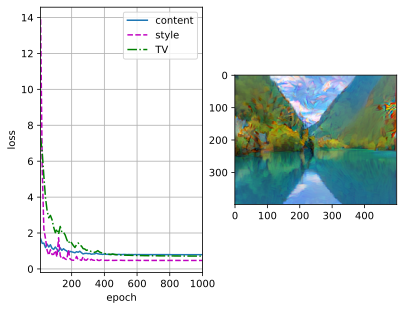

In [15]:
device, image_shape = 'cuda' , (400, 500)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 1000, 50)

In [17]:
postprocess(output).save('output.jpg')